While creating plots for various factors' effects on overall lap efficiency, we have collected data for a large number of metrics. For some, we have seen very strong correlations -- for example between accelerator position and motor current. For others, we see weaker or no correlation. One tool we can use to consisely present these correlations and possible reveal the underlying reasons for these is a correlation matrix, which displays r-values. We can use numpy's inbuilt tools to create such a matrix given a list of data sets.

Since we already have the means to effectively compute values on a per-lap basis, our data will be broken down by lap in this analysis. More continuous analysis might also yield interesting results, and should be studied further as well.

We begin this analysis by collecting various arrays (indexed by lap) with possibly correlated data.

In [14]:
from data_tools import TimeSeries, DBClient, FSGPDayLaps
from typing import Callable
import matplotlib.pyplot as plt
import numpy as np
import datetime

from numpy import ndarray

FSGP_TRACK_LEN_M = 5_070

driver_colours = {
    "Alex": "red",
    "Bryan": "orange",
    "Diego": "green",
    "Phoebe": "blue"
}

data_client = DBClient("can_log_prod")

Creating client with API Token: s4Z9_S6_O09kDzYn1KZcs7LVoCA2cVK9_ObY44vR4xMh-wYLSWBkypS0S0ZHQgBvEV2A5LgvQ1IKr8byHes2LA==
Creating client with Org: 8a0b66d77a331e96


In [15]:
def lap_current_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    raw_motor_current: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrent")
    motor_current_dir: TimeSeries = client.query_time_series(start_time, end_time, "BatteryCurrentDirection")

    # Align x-axes
    raw_motor_current, motor_current_dir = TimeSeries.align(raw_motor_current, motor_current_dir)
    # Make direction -1 or 1 instead of 1 or 0
    motor_current_sign = motor_current_dir * -2 + 1

    # Account for regen direction
    motor_current = raw_motor_current.promote(raw_motor_current * motor_current_sign)
    motor_current.units = "A"
    motor_current.meta["field"] = "Motor Current (adjusted for regen)"
    return motor_current

In [16]:
def lap_power_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    motor_voltage: TimeSeries = client.query_time_series(start_time, end_time, "BatteryVoltage")
    motor_current = lap_current_ts(start_time, end_time, client)

    # Align x-axes
    motor_voltage, motor_current = TimeSeries.align(motor_voltage, motor_current)

    motor_power = motor_current.promote(motor_current * motor_voltage)
    motor_power.units = "W"
    motor_power.meta["field"] = "Motor Power (adjusted for regen)"
    return motor_power

In [17]:
def lap_energy_ts(start_time: datetime, end_time: datetime, client) -> TimeSeries:
    motor_power = lap_power_ts(start_time, end_time, client)
    motor_energy = np.cumsum(motor_power) * motor_power.granularity
    motor_energy.units = "J"
    motor_energy.meta["field"] = "Motor Energy (regen adjusted)"
    return motor_energy

In [18]:
def lap_speed_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    lap_speed: TimeSeries = client.query_time_series(start_time, end_time, "VehicleVelocity")

    lap_speed.units = "m/s"
    lap_speed.meta["field"] = "Speed"
    return lap_speed

In [19]:
def lap_accel_ts(start_time: datetime, end_time: datetime, client: DBClient) -> TimeSeries:
    accelerator_position: TimeSeries = client.query_time_series(start_time, end_time, "AcceleratorPosition")

    accelerator_position.units = "%"
    accelerator_position.meta["field"] = "Accelerator Position"
    return accelerator_position

In [20]:
# Select which FSGP 2024 day to calculate lap efficiency for (1, 2 or 3)
laps1 = FSGPDayLaps(1)  # Corresponds to July 16th
laps3 = FSGPDayLaps(3)  # Corresponds to July 18th
day_1_idx = range(laps1.get_lap_count())
day_3_idx = range(laps3.get_lap_count())
num_laps = len(day_1_idx) + len(day_3_idx)


def collect_lap_data(query_func: Callable) -> ndarray:
    """
    Higher order function - computes `query_func` for all laps and returns the resulting array.

    :param query_func: must take in parameters (lap_start: datetime, lap_end:datetime, data_client:DBClient)
    :return: array of query_func results for all laps
    """
    lap_data = []
    # Iterate through all selected laps
    for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
        for lap_idx in lap_indices:
            lap_num = lap_idx + 1
            lap_start = day_laps.get_start_utc(lap_num)
            lap_end = day_laps.get_finish_utc(lap_num)
            lap_data.append(query_func(lap_start, lap_end, data_client))
            print(f"Processed data for day {day_laps.day} lap {lap_num}")
            print(f"{lap_start=}\n{lap_end=}")
            print(f"{query_func.__name__} result for lap {lap_num}: {lap_data[-1]}\n")
    return np.array(lap_data)

In [21]:
# Get lap average speed and driver data
lap_speeds = []
lap_drivers = []

for day_laps, lap_indices in zip((laps1, laps3), (day_1_idx, day_3_idx)):
    for lap_idx in lap_indices:
        lap_num = lap_idx + 1
        lap_start = day_laps.get_start_utc(lap_num)
        lap_end = day_laps.get_finish_utc(lap_num)
        lap_drivers.append(day_laps.get_lap_driver(lap_num))
        lap_speeds.append(day_laps.get_lap_mph(lap_num))

lap_drivers = np.array(lap_drivers)
lap_speeds = np.array(lap_speeds)

In [22]:
def get_lap_distance(start, end, client):
    speed_array: TimeSeries = lap_speed_ts(start, end, client)  # in meters per second
    return np.sum(speed_array) * speed_array.granularity  # in meters
lap_distances_m = collect_lap_data(get_lap_distance)

def lap_total_energy(start, end, client):
    return lap_energy_ts(start, end, client)[-1]
lap_energies = collect_lap_data(lap_total_energy)

lap_efficiencies = lap_energies / FSGP_TRACK_LEN_M

def get_speed_variance(start, end, client):
    return np.var(lap_speed_ts(start, end, client).base)
lap_speed_variances = collect_lap_data(get_speed_variance)

def get_power_variance(start, end, client):
    return np.var(lap_power_ts(start, end, client).base)
lap_power_variances = collect_lap_data(get_power_variance)

def get_accelerator_variance(start, end, client):
    return np.var(lap_accel_ts(start, end, client).base)
lap_accelerator_variances = collect_lap_data(get_accelerator_variance)

def get_average_acceleration(start, end, client):
    return np.mean(lap_accel_ts(start, end, client).base)
lap_average_accelerations = collect_lap_data(get_average_acceleration)

def get_current_variance(start, end, client):
    return np.var(lap_current_ts(start, end, client).base)
lap_current_variances = collect_lap_data(get_current_variance)

def get_average_current(start, end, client):
    return np.mean(lap_current_ts(start, end, client).base)
lap_average_currents = collect_lap_data(get_average_current)

def get_accel_variance(start, end, client):
    return np.var(np.diff(lap_speed_ts(start, end, client)))
lap_accel_variance = collect_lap_data(get_accel_variance)

def get_rms_accel(start, end, client):
    return np.sqrt(np.mean(np.square(np.diff(lap_speed_ts(start, end, client)))))
rms_accel = collect_lap_data(get_rms_accel)

Processed data for day 1 lap 1
lap_start=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
get_lap_distance result for lap 1: 5425.417711959088

Processed data for day 1 lap 2
lap_start=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
get_lap_distance result for lap 2: 5121.933540992318

Processed data for day 1 lap 3
lap_start=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
get_lap_distance result for lap 3: 5098.6438243688335

Processed data for day 1 lap 4
lap_start=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
get_lap_distance result for lap 4: 5182.615597100614

Processed data

In [24]:
def get_average_speed(start, end, client):
    return np.mean(lap_speed_ts(start, end, client).base)
lap_average_speeds = collect_lap_data(get_average_speed)

Processed data for day 1 lap 1
lap_start=datetime.datetime(2024, 7, 16, 15, 0, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
get_average_speed result for lap 1: 12.800596416687782

Processed data for day 1 lap 2
lap_start=datetime.datetime(2024, 7, 16, 15, 7, 4, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
get_average_speed result for lap 2: 14.033308913048517

Processed data for day 1 lap 3
lap_start=datetime.datetime(2024, 7, 16, 15, 13, 9, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
get_average_speed result for lap 3: 11.867964699494191

Processed data for day 1 lap 4
lap_start=datetime.datetime(2024, 7, 16, 15, 20, 19, tzinfo=datetime.timezone.utc)
lap_end=datetime.datetime(2024, 7, 16, 15, 27, 21, tzinfo=datetime.timezone.utc)
get_average_speed result for lap 4: 12.281399132944896

Process

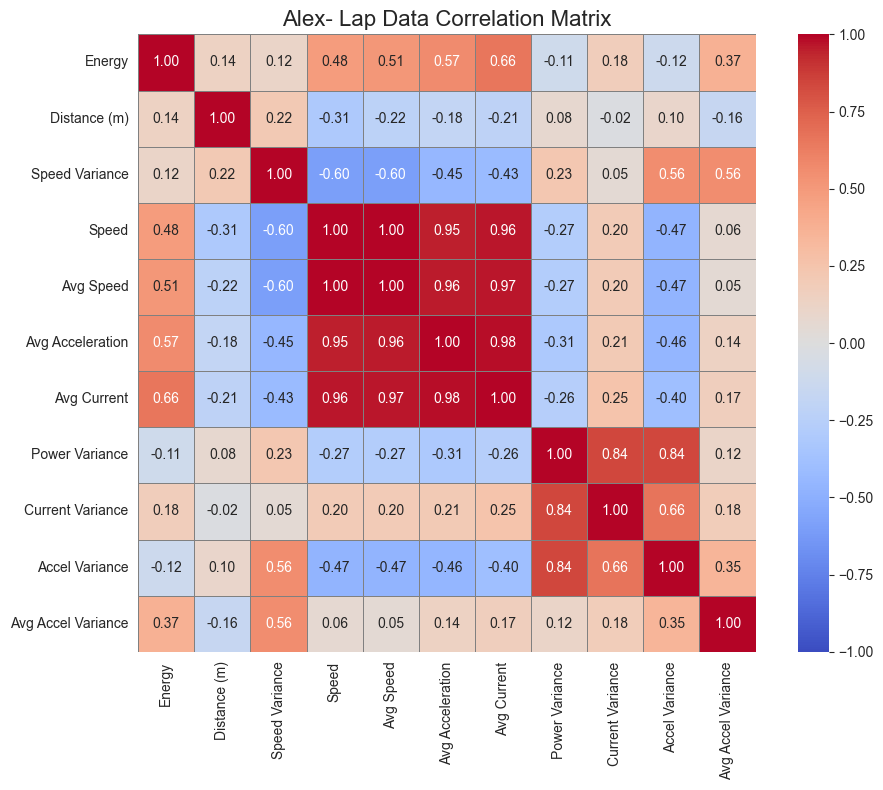

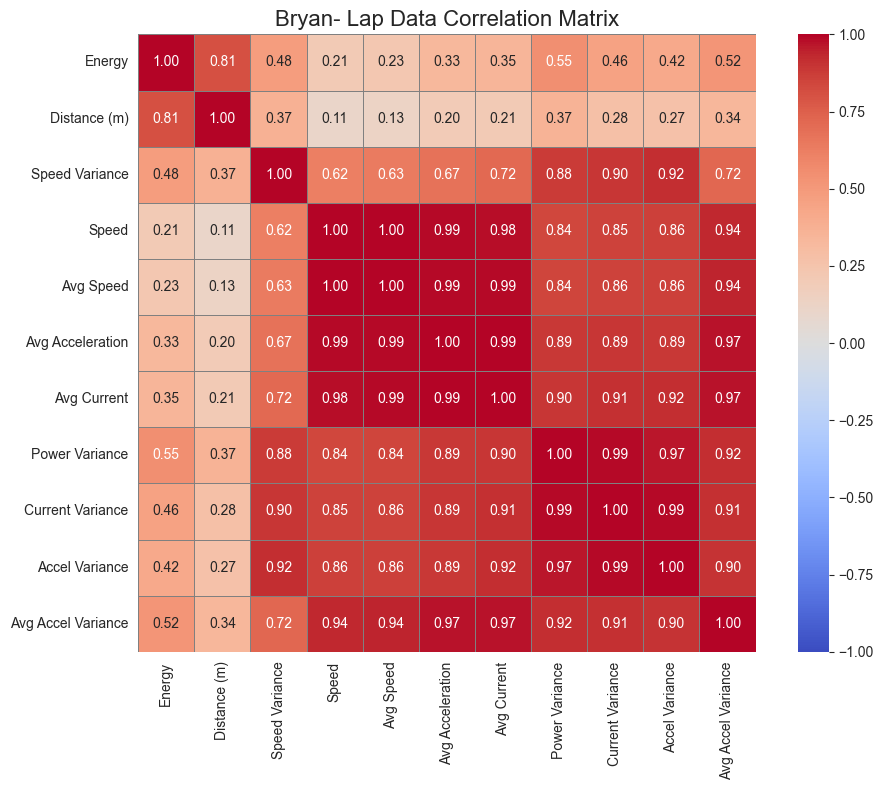

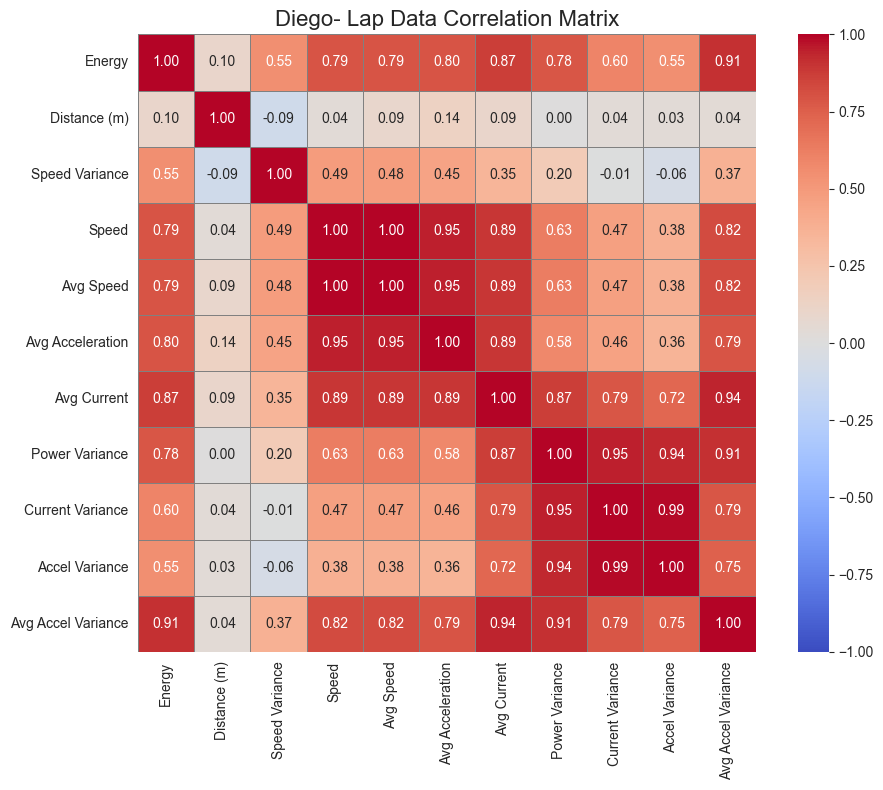

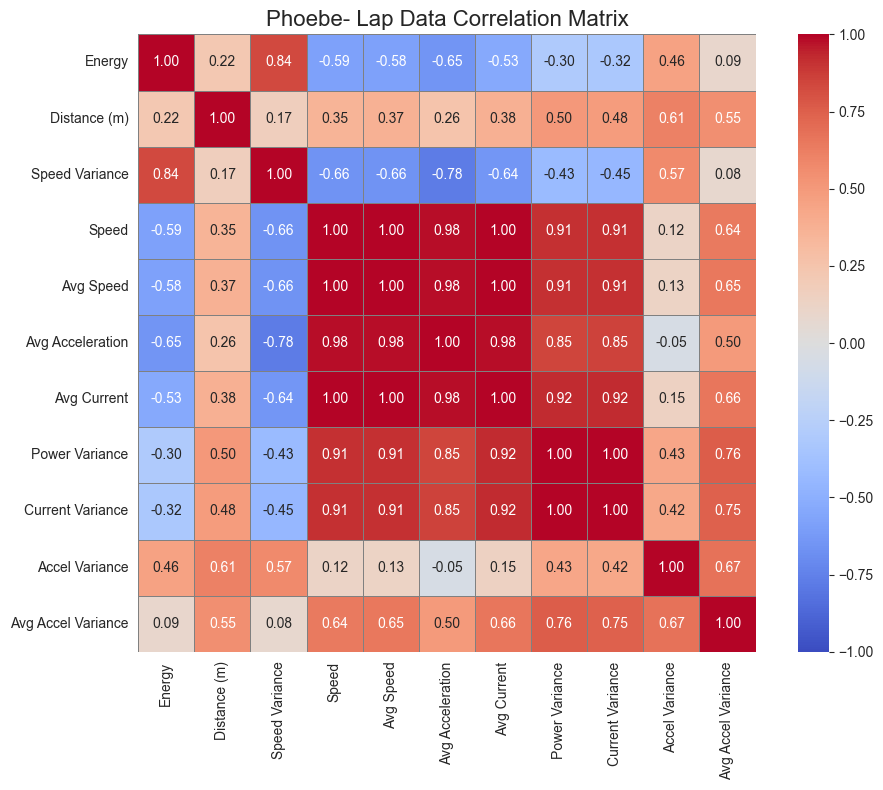

In [25]:
import pandas as pd
import seaborn as sns

lap_numbers = np.arange(1, 1 + num_laps)
data_dict = {
    'Energy': lap_energies,
    'Distance (m)': lap_distances_m,
    'Speed Variance': lap_speed_variances,
    'Speed': lap_speeds,
    'Avg Speed': lap_average_speeds,
    'Avg Acceleration': lap_average_accelerations,
    'Avg Current': lap_average_currents,
    'Power Variance': lap_power_variances,
    'Current Variance': lap_current_variances,
    'Accel Variance': lap_accelerator_variances,
    'Avg Accel Variance': lap_accel_variance
}

# Create a DataFrame
df = pd.DataFrame(data_dict)

# Compute the correlation matrix for each driver
lap_distance_filter = distance_filter = np.logical_and(lap_distances_m > 5000, lap_distances_m < 5200)

for driver in driver_colours.keys():
    combined_filter = np.logical_and(distance_filter, lap_drivers == driver)
    filtered_corr_matrix = df[combined_filter].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(filtered_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                vmin=-1, vmax=1, cbar=True, square=True, 
                linewidths=0.5, linecolor='gray')
    plt.title(f"{driver}- Lap Data Correlation Matrix", fontsize=16)
    plt.tight_layout()
    plt.show()  

In [26]:
import matplotlib.pyplot as plt

def generate_driver_scatter_plot(dataset_a, dataset_b, data_filter: np.ndarray=None):
    """
    Automatically generates a scatter plot for two datasets with colors corresponding to drivers.

    Parameters:
    - dataset_a: Data for the x-axis
    - dataset_b: Data for the y-axis
    - data_filter: Boolean mask to filter the dataset

    The function will:
    - Create a scatter plot with colors assigned to each driver.
    - Label the axes with 'Dataset A' and 'Dataset B'.
    """
    
    # Create the scatter plot
    for driver, colour in driver_colours.items():
        # Select the data points where the driver is the same
        if data_filter is not None:
            combined_filter = np.logical_and(lap_drivers == driver, data_filter)
        else:
            combined_filter = lap_drivers == driver
        # Plot the data for the current driver
        plt.scatter(dataset_a[combined_filter], dataset_b[combined_filter], 
                    c=colour, label=f"Driver: {driver}")
    
    # Labeling the axes
    plt.xlabel("Dataset A")
    plt.ylabel("Dataset B")
    
    # Add a legend to the plot
    plt.legend(title="Drivers", loc='upper right')
    
    # Show the plot
    plt.show()

## Validate Data

I'll take a couple "squares" from the charts above to verify that they are correct

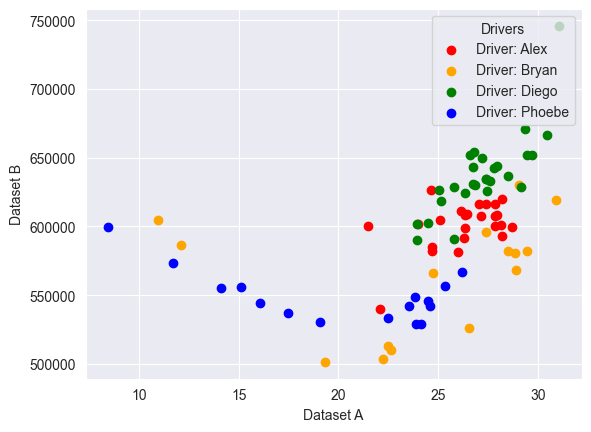

[[1.         0.48460406]
 [0.48460406 1.        ]]
[[1.         0.20726129]
 [0.20726129 1.        ]]
[[1.         0.79248938]
 [0.79248938 1.        ]]
[[ 1.         -0.58559969]
 [-0.58559969  1.        ]]


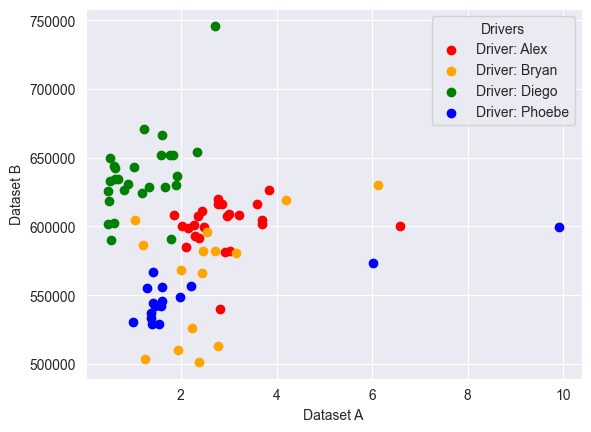

[[1.         0.11500613]
 [0.11500613 1.        ]]
[[1.         0.48079937]
 [0.48079937 1.        ]]
[[1.         0.55203363]
 [0.55203363 1.        ]]
[[1.         0.83538428]
 [0.83538428 1.        ]]


In [46]:
# Lap Energy vs. Lap Speed correlation
#     Alex: 0.48
#     Bryan: 0.21
#     Diego: 0.79
#     Phoebe: -0.59
generate_driver_scatter_plot(lap_speeds, lap_energies, distance_filter)
driver_filter = lambda driver_name: np.logical_and(lap_drivers == driver_name, distance_filter)
print(np.corrcoef(lap_speeds[driver_filter("Alex")], lap_energies[driver_filter("Alex")]))
print(np.corrcoef(lap_speeds[driver_filter("Bryan")], lap_energies[driver_filter("Bryan")]))
print(np.corrcoef(lap_speeds[driver_filter("Diego")], lap_energies[driver_filter("Diego")]))
print(np.corrcoef(lap_speeds[driver_filter("Phoebe")], lap_energies[driver_filter("Phoebe")]))

# Lap Energy vs. Speed Variance correlation
#     Alex: 0.12
#     Bryan: 0.48
#     Diego: 0.55
#     Phoebe: 0.84
generate_driver_scatter_plot(lap_speed_variances, lap_energies, distance_filter)
print(np.corrcoef(lap_speed_variances[driver_filter("Alex")], lap_energies[driver_filter("Alex")]))
print(np.corrcoef(lap_speed_variances[driver_filter("Bryan")], lap_energies[driver_filter("Bryan")]))
print(np.corrcoef(lap_speed_variances[driver_filter("Diego")], lap_energies[driver_filter("Diego")]))
print(np.corrcoef(lap_speed_variances[driver_filter("Phoebe")], lap_energies[driver_filter("Phoebe")]))